In [1]:
import pandas as pd

# Création d'un petit tableau
data = {
    "Nom": ["Alice", "Bob", "Charlie"],
    "Âge": [25, 30, 35],
    "Score": [85, 92, 78]
}
df = pd.DataFrame(data)
df


,Nom,Âge,Score
0,Alice,25,85
1,Bob,30,92
2,Charlie,35,78


# Import

In [2]:

import tensorflow as tf
import sys
from pathlib import Path
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, ReLU, Add, RandomRotation, RandomTranslation, RandomZoom, Rescaling, GlobalAveragePooling2D, RandomFlip
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
src_path = Path("..") / "src"
sys.path.append(str(src_path))
from src.CNNV2 import gradcam, display_gradcam

from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, precision_recall_curve,ConfusionMatrixDisplay
tensorboard_callback = TensorBoard(
    log_dir="./logsV2",         # répertoire pour stocker les logs
    histogram_freq=1,         # calculez les histogrammes des poids (et activations) toutes les 1 epoch
    write_graph=True,         # enregistre le graph du modèle
    write_images=True,        # enregistre des images des poids si possible
    update_freq='epoch'       # mise à jour à la fin de chaque epoch
)

# Paramètres globaux

In [3]:
# 📦 Paramètres globaux
LAYERS = [32, 64, 128,256] # Nombre de filtres pour chaque bloc résiduel
HEIGHT,WIDTH = 224,224 # Taille de l'image
OUTPUTSIZE = 1
EPOCH = 2
BATCH = 32
SEED = 42
PATIENCE = 4
LEARNINGRATE = 0.001
class_weight = {1:1.91, 0:0.68}
AUTOTUNE = tf.data.AUTOTUNE

In [4]:
def residual_block(x, filters):
    """
    Petit bloc résiduel :
      - Conv -> BN -> ReLU
      - Conv -> BN
      - skip connection + ReLU final
    """
    x_skip = x  # sauvegarde l'entrée pour la skip-connection
    
    # 1ère conv
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # 2ème conv
    x = Conv2D(filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)

    # skip connection
    x = Add()([x, x_skip]) 
    x = ReLU()(x)
    return x

def build_resnet_model(height=128, width=128, outputSize=1):
    inp = Input(shape=(height, width, 1))
    
    x = Rescaling(1./255)(inp) # 'x' prend la sortie de Rescaling(inp)

    # Bloc 1 : Conv + BN + Pool
    # La première couche Conv2D utilise 'x' (qui est la sortie de Rescaling)
    x = Conv2D(64, (3,3), padding='same')(x) 
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x)
    
    # Bloc résiduel 1
    x = residual_block(x, 64)
    x = MaxPooling2D((2,2))(x)

    # Bloc 2 : conv normal
    x = Conv2D(128, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x)
    
    # Bloc résiduel 2
    x = residual_block(x, 128)
    x = MaxPooling2D((2,2))(x)

    # Bloc 3 : conv normal
    x = Conv2D(256, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling2D((2,2))(x)

    # Bloc résiduel 3
    x = residual_block(x, 256)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    out = Dense(outputSize, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out)


# Load Datasets

In [5]:
# 1. Chargement et transformation des données
train_ds = tf.keras.utils.image_dataset_from_directory(
"dataset/initial/train",
validation_split=0.2,
subset="training",
seed=SEED,
image_size=(HEIGHT,WIDTH),
color_mode="grayscale",   # 1 canal
batch_size=BATCH,
shuffle=True,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/initial/train",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(HEIGHT,WIDTH),
    color_mode="grayscale",
    batch_size=BATCH,
    shuffle=True,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset/initial/test",
    image_size=(HEIGHT,WIDTH),
    color_mode="grayscale",
    batch_size=BATCH,
    shuffle=True,
)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


# Augment Train dataset

In [6]:
augment = tf.keras.Sequential([
        RandomRotation(factor=0.1), # Rotation de +/- 10% * 2*pi
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.1, width_factor=0.1),
        RandomFlip(mode='horizontal'),
    ])
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)
train_ds = (
    train_ds
      .map(lambda x, y: (augment(x, training=True), y),
           num_parallel_calls=AUTOTUNE)
      .prefetch(AUTOTUNE)
    )

# Création du modèle

In [7]:
model = build_resnet_model(height=HEIGHT, width=WIDTH, outputSize=OUTPUTSIZE)

# Compilation du modèle

In [8]:
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=LEARNINGRATE,weight_decay=0.0001), loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'),tf.keras.metrics.AUC(name='auc_roc'), tf.keras.metrics.AUC(curve='PR', name='auc_pr')])

# Entrainement du modèle

In [9]:
history = model.fit(train_ds,class_weight=class_weight, validation_data=val_ds, epochs=EPOCH,callbacks=[EarlyStopping(patience=PATIENCE, restore_best_weights=True),tensorboard_callback])

Epoch 1/2
131/131 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.8278 - auc_pr: 0.9437 - auc_roc: 0.8819 - loss: 0.4479 - precision: 0.8409 - recall: 0.9414 - val_accuracy: 0.8351 - val_auc_pr: 0.9839 - val_auc_roc: 0.9482 - val_loss: 0.3998 - val_precision: 0.8294 - val_recall: 0.9861
Epoch 2/2
131/131 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.8967 - auc_pr: 0.9789 - auc_roc: 0.9565 - loss: 0.2386 - precision: 0.8943 - recall: 0.9740 - val_accuracy: 0.7613 - val_auc_pr: 0.7613 - val_auc_roc: 0.5000 - val_loss: 3.2164 - val_precision: 0.7613 - val_recall: 1.0000


# Resumé

model.summary()

# Vision

In [10]:
# Concaténez tout le test_ds en mémoire
images = np.concatenate([x.numpy() for x, _ in test_ds], axis=0)      # shape (N,128,128,1)
labels = np.concatenate([y.numpy() for _, y in test_ds], axis=0)      # shape (N,)

# 2. Fonction de prédiction et d’affichage
def show_prediction(idx, colormap='gray'):
    img = images[idx]                   # (128,128,1)
    true_label = labels[idx]
    # Prépare pour la prédiction (ajoute batch dim)
    inp = np.expand_dims(img, axis=0)   # (1,128,128,1)
    pred = model.predict(inp)[0,0]      # probabilité [0…1]
    cls = "Pneumonia" if pred >= 0.5 else "Normal"

    # Affichage
    plt.figure(figsize=(4,4))
    plt.imshow(img[:,:,0], cmap=colormap)
    plt.title(f"Vrai: {int(true_label)}  →  Prédit: {pred:.2f} ({cls})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step


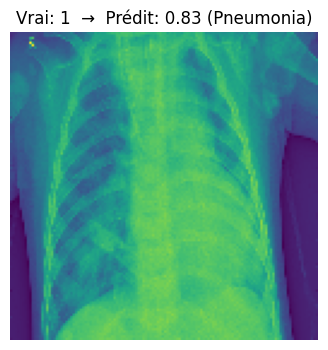

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


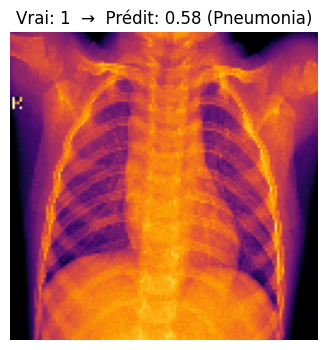

In [11]:
show_prediction(idx=5, colormap='viridis')
show_prediction(idx=6, colormap='inferno')

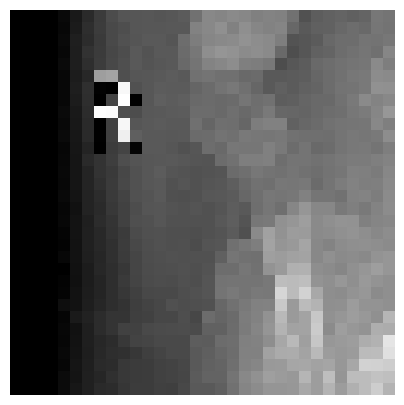

In [16]:
heatmap = gradcam(model, np.expand_dims(images[0],0), last_conv_layer_name="conv2d_3")
display_gradcam(images[0][:,:,0], heatmap, alpha=0.3)